In [1]:
from gbdxtools import CatalogImage, RDAImage
from gbdxtools.rda.interface import RDA
import sys
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.transform import resize
from gbdxtools.catalog import Catalog
from gbdxtools.images.catalog_image import CatalogImage
%matplotlib inline

rda = RDA()
    
    
class NDWIImage(RDAImage):
    def __new__(cls, cat_id, sensorPlatformName, bands="MS", **kwargs): 
        strip = rda.DigitalGlobeStrip(catId=cat_id, CRS="EPSG:4326", GSD="", 
                                      correctionType="DN", bands=bands, fallbackToTOA=True)
        if sensorPlatformName == "WORLDVIEW02" or sensorPlatformName == "WORLDVIEW03_VNIR":
            ndwi = rda.NDVIndex(strip, NIRBandIndex=1, RedBandIndex=7)
        else:
            print("NDWI can only be calculated for WORLDVIEW02 and WORLDVIEW03_VNIR")
            return
        graph = rda.Binarize(ndwi, threshold=0.6)
        self = super(NDWIImage, cls).__new__(cls, graph)
        self.cat_id = cat_id
        return self
    
    @property
    def _rgb_bands(self):
        return [1,2,4]



In [2]:
#Discovery Park
imageId = "10300100655F2300" # 2/26/2017
imageId_b4 = "1040010022AC5C00" # 10/7/2016
bbox = [-121.50398, 38.60119, -121.49774, 38.60665]

print(Catalog().get_strip_metadata(imageId))
print("\n")
print(Catalog().get_strip_metadata(imageId_b4))

{'offNadirAngle_min': 18.65126, 'offNadirAngle_start': 18.65126, 'targetAzimuth_min': 107.76445, 'multiResolution_min': 2.0465827, 'cloudCover': 0, 'sunAzimuth_max': 160.44936, 'targetAzimuth': 110.987915, 'multiResolution': 2.0742345, 'catalogID': '10300100655F2300', 'panResolution_max': 0.5239676, 'timestamp': '2017-02-26T19:19:20.807Z', 'sunAzimuth_min': 160.19759, 'browseURL': 'https://api.discover.digitalglobe.com/show?id=10300100655F2300&f=jpeg', 'targetAzimuth_max': 113.81737, 'sunAzimuth': 160.32028, 'sunElevation_min': 40.756985, 'offNadirAngle': 19.848396, 'stereoPair': None, 'platformName': 'WORLDVIEW02', 'multiResolution_start': 2.0465827, 'sunElevation': 41.282295, 'vendor': 'DigitalGlobe', 'scanDirection': 'Forward', 'panResolution_end': 0.5239676, 'panResolution_start': 0.5104689, 'targetAzimuth_end': 113.81737, 'panResolution_min': 0.5104689, 'offNadirAngle_max': 20.984762, 'multiResolution_end': 2.1018739, 'multiResolution_max': 2.1018739, 'sunElevation_max': 41.771664

In [3]:
c_b4 = CatalogImage(imageId_b4, pansharpen=True)
aoi_b4 = c_b4.aoi(bbox=bbox)
rgb_aoi_b4 = aoi_b4.rgb()
gsd1_b4 = c_b4.metadata['image']['groundSampleDistanceMeters']
print('GSD before image: {}m'.format(gsd1_b4))

c = CatalogImage(imageId, pansharpen=True)
aoi = c.aoi(bbox=bbox)
rgb_aoi = aoi.rgb()
gsd2 = c.metadata['image']['groundSampleDistanceMeters']
print('GSD after image: {}m'.format(gsd2))

GSD before image: 0.372m
GSD after image: 0.513m


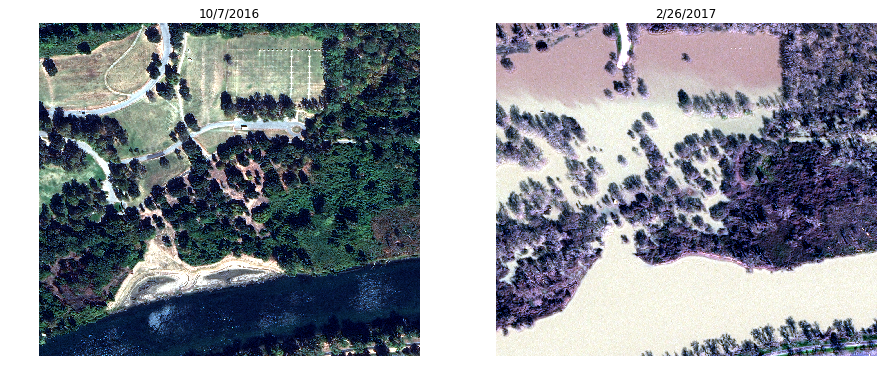

In [4]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.axis('off')
plt.title('10/7/2016')
plt.imshow(rgb_aoi_b4)

plt.subplot(122)
plt.axis('off')
plt.title('2/26/2017')
plt.imshow(rgb_aoi)

In [5]:
from shapely.geometry import shape

result = NDWIImage(imageId, Catalog().get_strip_metadata(imageId)['sensorPlatformName'])
seg = result[shape(aoi)]

result_b4 = NDWIImage(imageId_b4, Catalog().get_strip_metadata(imageId_b4)['sensorPlatformName'])
seg_b4 = result_b4[shape(aoi_b4)]


In [6]:
result_d = result.astype(np.uint8)
result_b4_d = result_b4.astype(np.uint8)

In [7]:
# save the results as geotiff
tif = result_d.geotiff(path="./DiscoveryPark_ndwi.tif", proj="EPSG:4326")
tif = result_b4_d.geotiff(path="./DiscoveryPark_ndwi_b4.tif", proj="EPSG:4326")

In [8]:
print(result.rda_id)
print(result_b4.rda_id)

a6bee41d0a811ab253c71297730350972b7e8439e6eaf33080cda9de439f177d
cd0203b99bb322678caef525eef40abf8ebfdb4e3e5484d0ff2cb38832e45864


In [9]:
seg_rgb = np.zeros((seg.shape[1], seg.shape[2], 3))
seg_rgb[:,:,2] = seg[0,:,:]
seg_rgb = resize(seg_rgb, (aoi.shape[1], aoi.shape[2], 3)).astype(int)
seg_rgb[:,:,2] = morphology.remove_small_objects(seg_rgb[:,:,2], int(1000/gsd2))
seg_rgb[:,:,2] = morphology.remove_small_holes(seg_rgb[:,:,2], int(1000/gsd2))
seg_rgb = seg_rgb.astype(np.float64)

seg_rgb_b4 = np.zeros((seg_b4.shape[1], seg_b4.shape[2], 3))
seg_rgb_b4[:,:,2] = seg_b4[0,:,:]
seg_rgb_b4 = resize(seg_rgb_b4, (aoi_b4.shape[1], aoi_b4.shape[2], 3)).astype(int)
seg_rgb_b4[:,:,2] = morphology.remove_small_objects(seg_rgb_b4[:,:,2], int(1000/gsd1_b4))
seg_rgb_b4[:,:,2] = morphology.remove_small_holes(seg_rgb_b4[:,:,2], int(1000/gsd1_b4))
seg_rgb_b4 =seg_rgb_b4.astype(np.float64)

/anaconda/envs/gbdx_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda/envs/gbdx_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda/envs/gbdx_py3/lib/python3.6/site-packages/skimage/morphology/misc.py:127: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/anaconda/envs/gbdx_py3/lib/python3.6/site-packages/skimage/morphology/misc.py:203: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boole

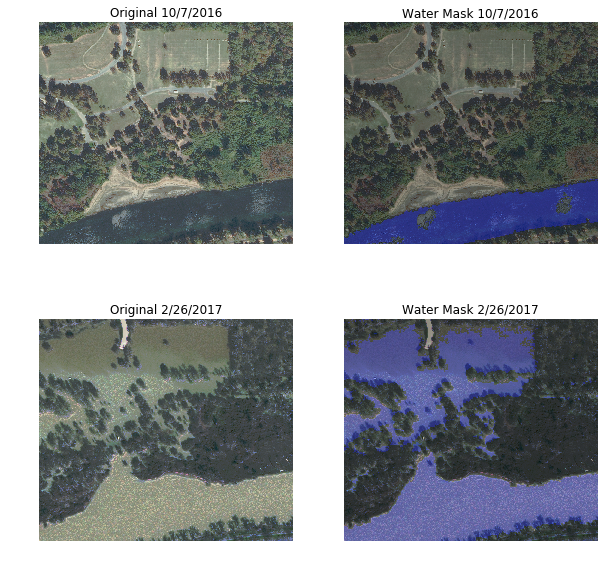

In [10]:
plt.figure(figsize=(10,10))
plt.subplot('221')
plt.axis('off')
plt.title('Original 10/7/2016')
plt.imshow(aoi_b4.rgb(blm=True, quiet=True))

plt.subplot('222')
plt.axis('off')
plt.title('Water Mask 10/7/2016')
plt.imshow(aoi_b4.rgb(blm=True, quiet=True))
plt.imshow(seg_rgb_b4, alpha=.3)

plt.subplot('223')
plt.axis('off')
plt.title('Original 2/26/2017')
plt.imshow(aoi.rgb(blm=True, quiet=True))

plt.subplot('224')
plt.axis('off')
plt.title('Water Mask 2/26/2017')
plt.imshow(aoi.rgb(blm=True, quiet=True))
plt.imshow(seg_rgb, alpha=.3)

plt.show()

In [11]:
from rasterio.features import shapes
from shapely import geometry
from shapely.ops import cascaded_union

arr_b4 = seg_rgb_b4[:,:,2].astype(np.uint8)
mask_b4 = arr_b4 != 0
polygons_b4 = [geometry.shape(geom).simplify(aoi_b4.affine.a) for geom, v in shapes(arr_b4, mask=mask_b4, transform=aoi_b4.affine)]
polygons_b4 = cascaded_union(polygons_b4)
features_b4 = [{"geometry": geometry.mapping(poly)} for poly in polygons_b4]
print('{} Features extracted from before image'.format(len(features_b4)))

arr = seg_rgb[:,:,2].astype(np.uint8)
mask = arr != 0
polygons = [geometry.shape(geom).simplify(aoi.affine.a) for geom, v in shapes(arr, mask=mask, transform=aoi.affine)]
polygons = cascaded_union(polygons)
features = [{"geometry": geometry.mapping(poly)} for poly in polygons]
print('{} Features extracted from after image'.format(len(features)))


42 Features extracted from before image
203 Features extracted from after image


In [12]:
from gbdxtools.vectors import Vectors
vs = Vectors()
vs.map(features=features_b4, zoom=15, style={"line-color": '#0080ff',
                        "line-opacity": .75,
                        "line-width": 2,
                        "line-translate": [-5,-5], 
                        "line-translate-anchor": "viewport"})

<IPython.core.display.Javascript object>

In [13]:
vs = Vectors()
vs.map(features=features, zoom=15, style={"line-color": '#0080ff',
                        "line-opacity": .75,
                        "line-width": 2,
                        "line-translate": [-5,-5], 
                        "line-translate-anchor": "viewport"})

<IPython.core.display.Javascript object>

In [14]:
class Extractor(object):
    def __init__(self, image):
        self._features = []
        self.image = image
        
    @property
    def features(self):
        return self._features
        
    def _extract(self, chunk, affine, gsd):
        arr = chunk[0,:,:].astype(np.uint8)
        arr = morphology.remove_small_objects(arr, int(1000/gsd))
        arr = morphology.remove_small_holes(arr, int(1000/gsd))
        arr = arr.astype(np.uint8)
        mask = arr != 0
        polygons = [geometry.shape(geom).simplify(affine.a) for geom, v in shapes(arr, mask=mask, transform=affine)]
        polygons = cascaded_union(polygons)
        if (isinstance(polygons, geometry.polygon.Polygon)):
            self._features += [{"geometry": geometry.mapping(polygons)}]
            return
        if len(polygons) == 0:
            return
        self._features += [{"geometry": geometry.mapping(poly)} for poly in polygons]
    

    def __setitem__(self, loc, chunk):
        affine = self.image[:, loc[1], loc[2]].affine
        self._extract(chunk, affine, self.image.metadata['image']['groundSampleDistanceMeters'])

In [79]:
import json
from shapely.ops import transform
from functools import partial
import pyproj


def dump_to_geojson(features, filename):
    collection = {
        'type': 'FeatureCollection', 
        'features': features
    }
    with open(filename, 'w') as dst:
        json.dump(collection, dst)
        
def _cascade_union(features, eps=0.00001):
    polygons = [shape(geom["geometry"]).buffer(eps, 1, join_style = geometry.JOIN_STYLE.mitre).buffer(-eps, 1, join_style=geometry.JOIN_STYLE.mitre) for geom in features]

    ### DELETE POLYGONS ####
    polygons_filtered = polygons
    for i, poly in enumerate(polygons):
        project = partial(
            pyproj.transform, 
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea', 
                lat1 =poly.bounds[1], 
                lat2=poly.bounds[3]))

        geom_area = transform(project, poly)
        if geom_area.area < 1500: # if polygon is less than 1500m^2, then remove
            del polygons_filtered[i]
            
    ### UNION POLYGONS ###
    polygons_filtered = cascaded_union(polygons_filtered)
    
    features_new = [{"geometry": geometry.mapping(poly)} for poly in polygons_filtered
                    ]
    return features_new

In [16]:
from functools import partial
import dask
from dask.array import store
from shapely.geometry import box 

threads = 64
threaded_get = partial(dask.threaded.get, num_workers=threads)
large_aoi_b4 = result_b4.aoi(bbox=box(-121.505926, 38.600126, -121.496343, 38.607686).buffer(0.005).bounds)
large_aoi = result.aoi(bbox=box(-121.505926, 38.600126, -121.496343, 38.607686).buffer(0.005).bounds)

In [17]:
extracts_b4 = Extractor(large_aoi_b4)
dsk = store(large_aoi_b4, extracts_b4, compute=False)
dsk.compute(scheduler=threaded_get)

len(extracts_b4.features)

8027

In [18]:
extracts = Extractor(large_aoi)
dsk = store(large_aoi, extracts, compute=False)
dsk.compute(scheduler=threaded_get)

len(extracts.features)

3255

In [89]:
new_features = _cascade_union(extracts.features)
print(len(new_features))
new_features_b4 = _cascade_union(extracts_b4.features)
print(len(new_features))

1584
1584


In [90]:
# import itertools

# eps = 5
# dist = 2
# polygons_combined = []

# for geom1, geom2 in itertools.combinations(polygons_filtered, 2):
#     distance = geom1.distance(geom2)
#     if distance < 2:
#         mp = MultiPolygon([geom1, geom2])
#         buf_geom = mp.buffer(eps, 1, join_style=geometry.JOIN_STYLE.mitre).buffer(-eps, 1, join_style=geometry.JOIN_STYLE.mitre)
#         polygons_combined.append({"geometry": buf_geom})

In [91]:
# save features
dump_to_geojson(new_features, 'large_aoi_ndwirda.json')
dump_to_geojson(new_features_b4, 'large_aoi_ndwirda_b4.json')

In [92]:
vs.map(features=new_features_b4, zoom=15, style={"line-color": '#0080ff',
                        "line-opacity": .75,
                        "line-width": 2,
                        "line-translate": [-5,-5], 
                        "line-translate-anchor": "viewport"})

<IPython.core.display.Javascript object>

In [93]:
vs.map(features=new_features, zoom=15, style={"line-color": '#0080ff',
                        "line-opacity": .75,
                        "line-width": 2,
                        "line-translate": [-5,-5], 
                        "line-translate-anchor": "viewport"})

<IPython.core.display.Javascript object>